In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE



In [2]:
df = pd.read_csv('data.csv')
df.head()

,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00081.au,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues.00022.au,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues.00031.au,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues.00012.au,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues.00056.au,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,...,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


<Axes: ylabel='count'>

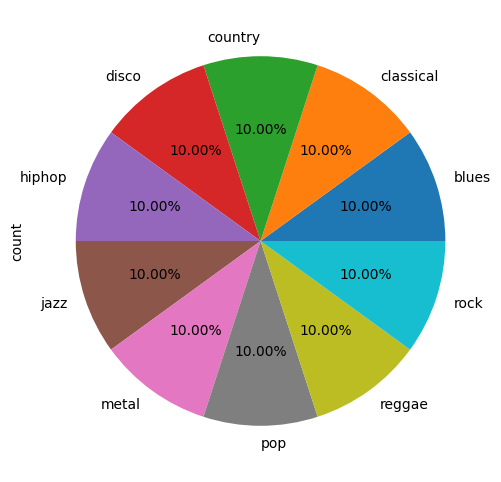

In [3]:
df["label"].value_counts().plot.pie(figsize=(6, 6), autopct="%.2f%%")

In [4]:
df.describe()

,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,119.601702,57.138000,0.378656,0.130929,2201.834226,2242.559613,4571.702159,0.103637,-144.479173,99.552199,...,-6.021121,4.471604,-4.797232,1.781547,-3.870275,1.147988,-3.967431,0.507303,-2.328779,-1.094875
std,28.297367,14.225728,0.081689,0.065685,715.961347,526.337663,1574.770035,0.041834,100.235661,31.331904,...,6.819018,6.717312,6.170919,5.009489,4.874423,4.579110,4.550650,3.869088,3.755574,3.837561
min,54.978391,18.000000,0.171782,0.005276,569.930721,897.994319,749.062137,0.021701,-552.064063,-1.527148,...,-28.052265,-15.805227,-27.542309,-12.598773,-17.545474,-15.693589,-17.227765,-11.975698,-18.504188,-19.935203
25%,99.384014,47.000000,0.319641,0.086625,1627.793931,1907.136505,3380.956639,0.070281,-200.695133,76.811480,...,-10.966826,-0.551576,-9.363372,-1.640080,-7.164838,-1.857098,-7.194297,-2.003979,-4.670281,-3.368000
50%,117.453835,56.000000,0.383075,0.122448,2209.468780,2221.408983,4658.671830,0.099539,-120.206072,98.452551,...,-5.920161,3.891842,-4.199810,1.879424,-3.614473,1.211944,-4.059109,0.669788,-2.391261,-1.155198
75%,135.999178,65.250000,0.435974,0.175793,2691.969702,2578.474352,5534.197785,0.132007,-73.895019,119.893638,...,-1.004241,9.706133,-0.161017,5.155264,-0.323536,4.350694,-0.842968,3.112518,0.149070,1.303739
max,234.907670,117.000000,0.663573,0.398012,4434.439444,3509.578677,8676.405868,0.274829,42.034587,193.096518,...,17.421038,23.037571,13.054333,18.161663,12.357588,13.468803,11.489994,15.379257,14.686910,15.368966


In [5]:
df.isnull().sum().sort_values(ascending=False)

filename              0
tempo                 0
mfcc20                0
mfcc19                0
mfcc18                0
mfcc17                0
mfcc16                0
mfcc15                0
mfcc14                0
mfcc13                0
mfcc12                0
mfcc11                0
mfcc10                0
mfcc9                 0
mfcc8                 0
mfcc7                 0
mfcc6                 0
mfcc5                 0
mfcc4                 0
mfcc3                 0
mfcc2                 0
mfcc1                 0
zero_crossing_rate    0
rolloff               0
spectral_bandwidth    0
spectral_centroid     0
rmse                  0
chroma_stft           0
beats                 0
label                 0
dtype: int64

In [6]:
df.drop(["filename"], axis=1, inplace=True)

In [8]:
x = df.drop(["label"], axis=1)
y = df["label"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [13]:
model = RandomForestClassifier(random_state=42)

In [14]:
# perform forward selection
selected_features = []
best_accuracy = 0
for i in range(x_train.shape[1]):
    best_features = []
    for feature_idx in range(x_train.shape[1]):
        if feature_idx not in best_features:
            selected_features.append(feature_idx)
            model.fit(x_train[:, selected_features], y_train)
            y_pred = model.predict(x_test[:, selected_features])
            accuracy = accuracy_score(y_test, y_pred)

            if accuracy>best_accuracy:
                best_accuracy = accuracy
                best_features.append(feature_idx)
            selected_features.remove(feature_idx)
    if best_features is not None:
        selected_features.append(best_features)
        print("selected features: {}".format(best_features))


InvalidIndexError: (slice(None, None, None), [0])

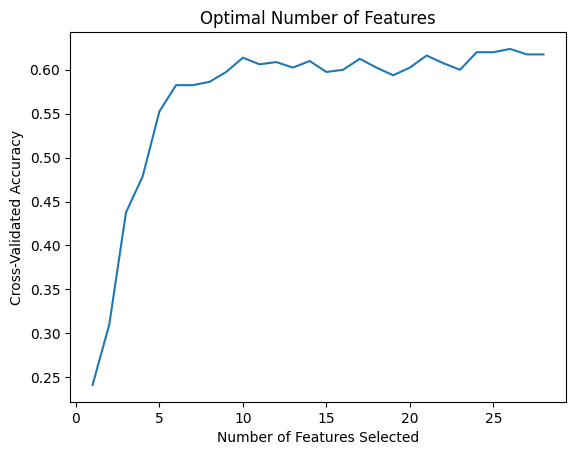

In [17]:
feature_range = range(1, len(x.columns) + 1)
cv_scores = []

for n_features in feature_range:
    rfe = RFE(model, n_features_to_select=n_features)
    X_train_rfe = rfe.fit_transform(x_train, y_train)
    cv_score = cross_val_score(model, X_train_rfe, y_train, cv=5, scoring='accuracy').mean()
    cv_scores.append(cv_score)


plt.plot(feature_range, cv_scores)
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Optimal Number of Features')
plt.show()


In [19]:
#Feature Selection with Optimal Number for Highest Accuracy
optimal_n_features = feature_range[np.argmax(cv_scores)]

#Fitting the Model on the Selected Features
rfe = RFE(model, n_features_to_select=optimal_n_features)
X_train_rfe = rfe.fit_transform(x_train, y_train)

In [20]:
print("Selected Features:", optimal_n_features)

Selected Features: 26


In [21]:
# Names of the selected features
selected_features = x_train.columns[rfe.get_support()]

print("Optimal Selected Features:")
print(selected_features)

Optimal Selected Features:
Index(['tempo', 'chroma_stft', 'rmse', 'spectral_centroid',
       'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2',
       'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10',
       'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17',
       'mfcc18', 'mfcc20'],
      dtype='object')


In [22]:
model.fit(X_train_rfe,y_train)

RandomForestClassifier(random_state=42)

In [24]:
X_test_rfe = rfe.transform(x_test)
y_pred = model.predict(X_test_rfe)

In [27]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)


Accuracy: 0.60
Classification Report:
               precision    recall  f1-score   support

       blues       0.95      0.62      0.75        29
   classical       0.86      0.92      0.89        13
     country       0.50      0.38      0.43        24
       disco       0.50      0.44      0.47        18
      hiphop       0.30      0.46      0.36        13
        jazz       0.52      0.71      0.60        21
       metal       0.90      0.90      0.90        20
         pop       0.62      0.62      0.62        16
      reggae       0.55      0.64      0.59        25
        rock       0.47      0.43      0.45        21

    accuracy                           0.60       200
   macro avg       0.62      0.61      0.61       200
weighted avg       0.63      0.60      0.61       200

